In [1]:
import sys
import unittest

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

sns.set_style("whitegrid", {'axes.grid' : False})

import torch
import torchvision
import torchvision.transforms as transforms

import torch.nn as nn
import torch.nn.functional as F

import torch.optim as optim

from torchinfo import summary

# %matplotlib inline

# Tensors

A tensor is an n-dimensional array consisting of elements of the same type. Every tensor has an associated shape that describes the dimensions of the tensor. For example, the shape of a 4D tensor would have four numbers that specify the size of each of the four dimensions.

- **vector:** 1D tensor with shape `[N]` where N denotes the number of elements
- **matrix:** 2D tensor with shape `[R, C]` where R and C denote the number of rows and columns, respectively
- **RGB image:** 3D tensor with shape `[C, H, W]` where C denotes the number of channels (representing color) and H and W denote the height and width, respectively

The number of tensor dimensions is known as "the rank of the tensor". Each tensor dimension is known as "an axis" of the tensor. An axis with a dimension of one is known as a singleton axis. Example usage: "In a rank four tensor of shape `[N, C, H, W]`, N denotes the dimension/size of the leading axis."

A tensor containing a batch of images would typically have the following shape: [N, C, H, W]. `N` indicates the number of images in the batch, `C` indicates the number of channels (one for grayscale images and typically three for color images), H and W are the height and width of the image respectively. Note that the dimensions of each image is fixed; we cannot store images of different sizes in the same tensor.

# Convolution Arithmetic

The convolution operation takes two tensors as input and results in one tensor as output (sometimes, we add a "bias" tensor to the result after convolving). The shape of the output tensor depends on the shape of the input tensor, weights/filters tensor, and convolution configuration such as padding.

The convolution layer in a neural network generally convolves the same input with many filters (ranging from few dozen to hundreds to thousands). It is equivalent to convolving the image with each filter separately and then concatenating the results into a single tensor. We also often convolve the same set of filters on a collection of input tensors (like in minibatch gradient descent).

Using the visualizations below as an aid, write a function that outputs the shape of the output tensor for a given input shape, filters shape, and convolution configuration.

<table>
  <tr>
    <td><img width="150px" src="https://raw.githubusercontent.com/vdumoulin/conv_arithmetic/master/gif/no_padding_no_strides.gif"></td>
    <td><img width="150px" src="https://raw.githubusercontent.com/vdumoulin/conv_arithmetic/master/gif/same_padding_no_strides.gif"></td>
    <td><img width="150px" src="https://raw.githubusercontent.com/vdumoulin/conv_arithmetic/master/gif/full_padding_no_strides.gif"></td>
  </tr>
  <tr>
    <td>No padding, no strides</td>
    <td>Padding of one, no strides</td>
    <td>Padding of two, no strides</td>
  </tr>
  <tr>
    <td><img width="150px" src="https://raw.githubusercontent.com/vdumoulin/conv_arithmetic/master/gif/no_padding_strides.gif"></td>
    <td><img width="150px" src="https://raw.githubusercontent.com/vdumoulin/conv_arithmetic/master/gif/padding_strides.gif"></td>
    <td><img width="150px" src="https://raw.githubusercontent.com/vdumoulin/conv_arithmetic/master/gif/padding_strides_odd.gif"></td>
  </tr>
  <tr>
    <td>No padding, stride of two</td>
    <td>Padding of one, stide of two</td>
    <td>Padding of one, stride of two</td>
  </tr>
</table>

**References:**
"A guide to convolution arithmetic for deep learning", https://arxiv.org/abs/1603

License for images: https://github.com/vdumoulin/conv_arithmetic/blob/master/LICENSE


In [2]:
def getConvolutionOutputShape(B, C, H, W, K, M, N, Ph=0, Pw=0, Sh=1, Sw=1):
  """
    Computes the output shape of 2D convolution for a given input and filters shape

    Input shape: [B, C, H, W]
    Filters shape: [K, C, H, W]
    
    Padding and strides are relevant for spatial dimensions only (height and width).

  Args:
    B: batch size
    C: number of input channels
    H: height of the input
    W: width of the input
    K: number of filters
    M: height of the filters
    N: width of the filters
    Ph: vertical padding
    Pw: horizontal padding
    Sh: vertical stride
    Sw: horizontal stride
  """

  output_shape = np.zeros(4, dtype=int)

  # the calculation is independent and identical for each spatial axis
  def calculate_output_dim(input_size, filter_size, padding, stride):
    """returns the output dimension for a spatial axis"""
    # YOUR CODE BEGINS HERE
    # 0, s, 2s, (m-1)s <= (n+2p-k) -> get m
    return np.floor((input_size + 2*padding - filter_size)/stride)+1
    # YOUR CODE ENDS HERE

  # YOUR CODE BEGINS HERE
  output_shape[0] = B   # Same number of batches
  output_shape[1] = K   # Number of channels of output
  output_shape[2] = calculate_output_dim(H, M, Ph, Sh)  # Height
  output_shape[3] = calculate_output_dim(W, N, Pw, Sw)  # Width
  # YOUR CODE ENDS HERE

  return list(output_shape)

In [3]:
class Test_getConvolutionOutputShape(unittest.TestCase):
  def test_simple(self):
    self.assertEqual(getConvolutionOutputShape(1, 1, 28, 32, 16, 3, 3), [1, 16, 26, 30])
    self.assertEqual(getConvolutionOutputShape(5, 3, 32, 28, 32, 3, 3), [5, 32, 30, 26])
    self.assertEqual(getConvolutionOutputShape(7, 256, 28, 28, 64, 3, 1), [7, 64, 26, 28])
    self.assertEqual(getConvolutionOutputShape(11, 256, 28, 28, 128, 1, 3), [11, 128, 28, 26])
    self.assertEqual(getConvolutionOutputShape(13, 1, 64, 64, 16, 5, 5), [13, 16, 60, 60])

  def test_padding(self):
    self.assertEqual(getConvolutionOutputShape(1, 1, 32, 28, 16, 3, 3, 1, 1), [1, 16, 32, 28])
    self.assertEqual(getConvolutionOutputShape(1, 16, 28, 32, 32, 3, 3, 3, 3), [1, 32, 32, 36])
    self.assertEqual(getConvolutionOutputShape(1, 33, 28, 28, 64, 3, 1, 1, 0), [1, 64, 28, 28])
    self.assertEqual(getConvolutionOutputShape(1, 64, 28, 28, 128, 1, 3, 0, 1), [1, 128, 28, 28])
    self.assertEqual(getConvolutionOutputShape(1, 32, 28, 28, 128, 1, 3, 0, 1), [1, 128, 28, 28])
    self.assertEqual(getConvolutionOutputShape(1, 4, 7, 11, 16, 5, 5, 2, 2), [1, 16, 7, 11])

  def test_strides(self):
    self.assertEqual(getConvolutionOutputShape(1, 1, 28, 28, 16, 3, 3, 0, 0, 2, 2), [1, 16, 13, 13])
    self.assertEqual(getConvolutionOutputShape(1, 32, 28, 28, 32, 3, 3, 1, 1, 2, 2), [1, 32, 14, 14])
    self.assertEqual(getConvolutionOutputShape(1, 64, 28, 28, 64, 3, 1, 2, 2, 2, 2), [1, 64, 15, 16])
    self.assertEqual(getConvolutionOutputShape(1, 128, 28, 28, 128, 1, 3, 0, 1, 4, 4), [1, 128, 7, 7])

  def test_misc(self):
    self.assertEqual(getConvolutionOutputShape(1, 1, 13, 13, 16, 1, 1), [1, 16, 13, 13])

unittest.main(Test_getConvolutionOutputShape(), argv=[''], verbosity=2, exit=False)

test_misc (__main__.Test_getConvolutionOutputShape) ... ok
test_padding (__main__.Test_getConvolutionOutputShape) ... ok
test_simple (__main__.Test_getConvolutionOutputShape) ... ok
test_strides (__main__.Test_getConvolutionOutputShape) ... ok

----------------------------------------------------------------------
Ran 4 tests in 0.003s

OK


# Convolution

Implement the `convolve2d` that convolves a filter (unit strides and zero padding) on a greyscale image. The animated visual aid shows this configuration.

<img src="https://raw.githubusercontent.com/vdumoulin/conv_arithmetic/master/gif/no_padding_no_strides.gif"/>

In [4]:
def convolve2d(image, kernel):
  """
    Convolve a 2D image with a kernel (2D filter)

  Args:
    image: matrix of shape H x W
    kernel: matrix of shape M x N
  """

  image = np.asarray(image)
  kernel = np.asarray(kernel)

  H, W = image.shape
  M, N = kernel.shape

  # YOUR CODE BEGINS HERE
  sp = getConvolutionOutputShape(1, 1, H, W, 1, M, N)
  result_H = sp[2]  # Height
  result_W = sp[3]  # Width
  # YOUR CODE ENDS HERE

  result = np.zeros((result_H, result_W), dtype=np.float32)
  # YOUR CODE BEGINS HERE
  # Implement convolution using two loops
  for i in range(0, H-M+1): # Along rows
    for j in range(0, W-N+1): # Along columns
      # Multiply and substitute
      result[i, j] = np.sum(image[i:i+M, j:j+N]*kernel)
  # YOUR CODE ENDS HERE

  return result

In [5]:
def convolve2d_ref(image, kernel):
  from scipy import signal
  return signal.correlate2d(image, kernel, mode='valid')

class test_convolve2d(unittest.TestCase):
  def test(self):
    image1 = np.random.random((16, 16))
    kernel1 = np.ones((3, 3), dtype=np.float32)
    kernel1 /= np.sum(kernel1)
    self.assertTrue(np.allclose(convolve2d(image1, kernel1), convolve2d_ref(image1, kernel1), rtol=1e-05, atol=1e-08))

    image2 = np.random.random((32, 32))
    kernel2 = np.asarray([[1, 2, 3], [4, 5, 6], [6, 7, 8]], dtype=np.float32)
    kernel2 /= np.sum(kernel2)
    self.assertTrue(np.allclose(convolve2d(image2, kernel2), convolve2d_ref(image2, kernel2), rtol=1e-05, atol=1e-08))

    image3 = np.random.random((256, 256))
    kernel3 = np.asarray([[0, 1, 0], [1, -4, 1], [0, 1, 0]], dtype=np.float32)
    kernel3 /= np.sum(np.abs(kernel3))
    self.assertTrue(np.allclose(convolve2d(image3, kernel3), convolve2d_ref(image3, kernel3), rtol=1e-05, atol=1e-08))

unittest.main(test_convolve2d(), argv=[''], verbosity=2, exit=False)

test (__main__.test_convolve2d) ... ok

----------------------------------------------------------------------
Ran 1 test in 0.683s

OK


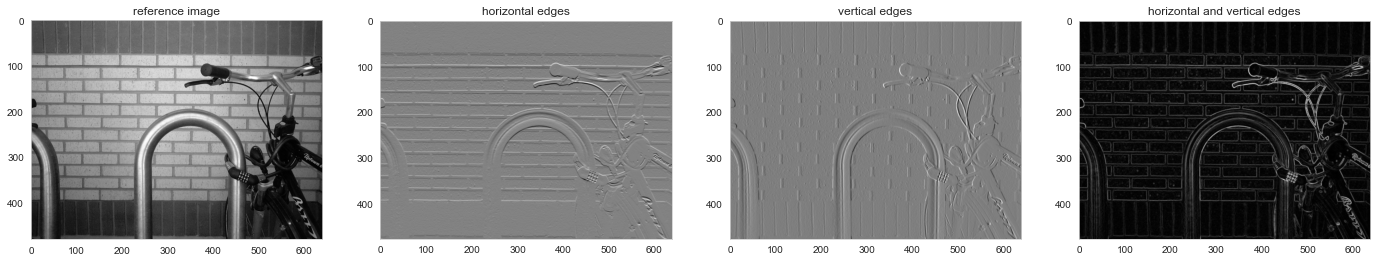

In [6]:
import skimage.io as sio
image = sio.imread("https://upload.wikimedia.org/wikipedia/commons/3/3f/Bikesgray.jpg", as_gray=True)

# https://en.wikipedia.org/wiki/Sobel_operator
sobel_filter_horizontal = np.asarray([
  [ 1,  2,  1],
  [ 0,  0,  0],
  [-1, -2, -1]
], dtype=np.float32)

sobel_filter_vertical = sobel_filter_horizontal.T

# convolve image with Sobel operators using your implementation
image_sobel_h = convolve2d(image, sobel_filter_horizontal)
image_sobel_v = convolve2d(image, sobel_filter_vertical)
image_sobel_hv =  np.sqrt(image_sobel_h**2 + image_sobel_v**2)

# convolve image with Sobel operators using reference implementation
image_sobel_h_ref = convolve2d_ref(image, sobel_filter_horizontal)
image_sobel_v_ref = convolve2d_ref(image, sobel_filter_vertical)

fig, axes = plt.subplots(1, 4, figsize=(24,6))
axes[0].imshow(image, cmap='gray')
axes[0].set_title("reference image")
axes[1].imshow(image_sobel_h, cmap='gray')
axes[1].set_title("horizontal edges")
axes[2].imshow(image_sobel_v, cmap='gray')
axes[2].set_title("vertical edges")
axes[3].imshow(image_sobel_hv, cmap='gray')
axes[3].set_title("horizontal and vertical edges")
plt.show()

# Convolution as Matrix Multiplication

Convolution is a linear operation. We can represent convolution as a matrix multiplication of a transformed filter matrix with the input matrix.

Consider an input $\mathbf{X}$ and a kernel $\mathbf{W}$.

$$$$

$$\mathbf{X} = \begin{pmatrix}x_{00} & x_{01} & x_{02} \\ x_{10} & x_{11} & x_{12} \\ x_{20} & x_{21} & x_{22} \end{pmatrix}$$

$$\mathbf{W} = \begin{pmatrix}w_{00} & w_{01} \\ w_{10} & w_{11} \end{pmatrix}$$

$$$$

Let the result of the convolution of $\mathbf{X}$ with $\mathbf{W}$ be denoted by $\mathbf{Y}$.

$$\mathbf{Y} = \mathbf{X} * \mathbf{Y}$$

$$\mathbf{Y} = \begin{pmatrix}
w_{00}*x_{00} + w_{01}*x_{01} + w_{10}*x_{10} + w_{11}*x_{11} &
w_{00}*x_{01} + w_{01}*x_{02} + w_{10}*x_{11} + w_{11}*x_{12} \\
w_{00}*x_{10} + w_{01}*x_{11} + w_{10}*x_{20} + w_{11}*x_{21} &
w_{00}*x_{11} + w_{01}*x_{12} + w_{10}*x_{21} + w_{11}*x_{22}
 \end{pmatrix}$$

$$$$

We can express the result as matrix multiplication of a transformed weight matrix with the input matrix.

$$\mathbf{Y} = \begin{pmatrix}
w_{00} & w_{01} & 0 & w_{10} & w_{11} & 0 & 0 & 0 & 0 \\
0 & w_{00} & w_{01} & 0 & w_{10} & w_{11} & 0 & 0  & 0\\
0 & 0 & 0 & w_{00} & w_{01} & 0 & w_{10} & w_{11} & 0 \\
0 & 0 & 0 & 0 & w_{00} & w_{01} & 0 & w_{10} & w_{11}
\end{pmatrix}
\space
\begin{pmatrix}
x_{00} \\
x_{01} \\
x_{02} \\
x_{10} \\
x_{11} \\
x_{12} \\
x_{20} \\
x_{21} \\
x_{22}
\end{pmatrix}$$

1. Assuming the input and kernel shape to be `[H, W]` and `[M, N]` respectively, what is the shape of the transformed kernel matrix?
2. Complete the `transform_kernel` function. It must construct the transformed kernel matrix for a given input shape and kernel matrix.
3. Complete the `convolve2d_matmul` function. It must convolve the input with the given kernel using the transformed matrix.

**References:**
- https://github.com/alisaaalehi/convolution_as_multiplication

## Answers

1. Write your answer here

### Answer 1: Shape of the transformed kernel matrix

Input is of shape `[H, W]` and kernel is of shape `[M, N]`. Assuming that the stride is 1 and that there is no padding, we get the resulting image (after convolution) to be of shape `[H-M+1, W-N+1]` (as implemented in `getConvolutionOutputShape` function). The _transformed kernel matrix_ should have the same number of rows as there are pixels in the resulting image, and it should have the same number of columns as there are pixels in the input image (which is obviously larger than the kernel).

Therefore, the shape of the transformed kernel matrix is `[((H-M+1)*(W-N+1)), (H*W)]`.
It must be a doubly block circulant matrix (a special case of [Toeplitz matrix](https://en.wikipedia.org/wiki/Toeplitz_matrix#Discrete_convolution)).


### Answer 2 and 3

Functions `transform_kernel` (answer 2) and `convolve2d_matmul` (answer 3) are declared below

In [13]:
# 2. Completing the transform_kernel function
def transform_kernel(image, kernel):
  """
    Transform kernel matrix into a new matrix such that matrix multiplication of
    the transformed matrix with the flattened input gives the result of convolution.

  Args:
    image: matrix of shape H x W
    kernel: matrix of shape M x N
  """

  image = np.asarray(image)
  kernel = np.asarray(kernel)

  H, W = image.shape
  M, N = kernel.shape

  # YOUR CODE BEGINS HERE
  sp = getConvolutionOutputShape(1, 1, H, W, 1, M, N) # b,k,h,w
  result_H = sp[2]  # height of the output
  result_W = sp[3]  # width of the output
  # YOUR CODE ENDS HERE

  transformed_kernel = np.zeros((result_H * result_W, H * W), dtype=np.float32)
  # YOUR CODE BEGINS HERE
  tk_row = np.zeros(H * W, dtype=np.float32)  # A row (will roll)
  for i in range(M):  # Rows of kernel as a sparse vector (rows)
    tk_row[W*i:W*i+N] = kernel[i]
  for i in range(result_H*result_W):
    rv = np.roll(tk_row, (i//result_W)*W + i%result_W)
    transformed_kernel[i] = rv
  # YOUR CODE ENDS HERE

  return transformed_kernel

# 3. Completing the convolve2d_matmul function
def convolve2d_matmul(image, kernel):
  """
    Convolve a 2D image with a 2D kernel

  Args:
    image: matrix of shape H x W
    kernel: matrix of shape M x N
  """

  image = np.asarray(image)
  kernel = np.asarray(kernel)
  
  H, W = image.shape
  M, N = kernel.shape

  # YOUR CODE BEGINS HERE
  sp = getConvolutionOutputShape(1, 1, H, W, 1, M, N) # b,k,h,w
  result_H = sp[2]  # height of the output = H - M + 1
  result_W = sp[3]  # width of the output = W - N + 1
  # YOUR CODE ENDS HERE

  # YOUR CODE BEGINS HERE
  # 1. compute transformed kernel
  trans_k = transform_kernel(image, kernel)
  # 2. flatten input (reshape the 2D input to a 1D column vector)
  in_flat = image.flatten()
  # 3. matrix multiplication
  out_flat = trans_k @ in_flat
  # 4. reshape result (reshape back to 2D output from a 1D column vector)
  result = out_flat.reshape(result_H, result_W)
  # YOUR CODE ENDS HERE

  return result

In [14]:
def convolve2d_ref(image, kernel):
  from scipy import signal
  return signal.correlate2d(image, kernel, mode='valid')

class test_convolve2d_matmul(unittest.TestCase):
  def test(self):
    image1 = np.random.random((16, 16))
    kernel1 = np.ones((3, 3), dtype=np.float32)
    kernel1 /= np.sum(kernel1)
    self.assertTrue(np.allclose(convolve2d_matmul(image1, kernel1), convolve2d_ref(image1, kernel1), rtol=1e-05, atol=1e-08))

    image2 = np.random.random((32, 32))
    kernel2 = np.asarray([[1, 2, 3], [4, 5, 6], [6, 7, 8]], dtype=np.float32)
    kernel2 /= np.sum(kernel2)
    self.assertTrue(np.allclose(convolve2d_matmul(image2, kernel2), convolve2d_ref(image2, kernel2), rtol=1e-05, atol=1e-08))

    image3 = np.random.random((64, 64))
    kernel3 = np.asarray([[0, 1, 0], [1, -4, 1], [0, 1, 0]], dtype=np.float32)
    kernel3 /= np.sum(np.abs(kernel3))
    self.assertTrue(np.allclose(convolve2d_matmul(image3, kernel3), convolve2d_ref(image3, kernel3), rtol=1e-05, atol=1e-08))

unittest.main(test_convolve2d_matmul(), argv=[''], verbosity=2, exit=False)

test (__main__.test_convolve2d_matmul) ... ok

----------------------------------------------------------------------
Ran 1 test in 0.218s

OK


## Comparing convolutional layer with fully-connected layer

$$\mathbf{Y}_{fc} = \begin{pmatrix}
w_{00} & w_{01} & w_{02} & w_{03} & w_{04} & w_{05} & w_{06} & w_{07} & w_{08} & w_{09} \\
w_{10} & w_{11} & w_{12} & w_{13} & w_{14} & w_{15} & w_{16} & w_{17} & w_{18} & w_{19} \\
w_{20} & w_{21} & w_{22} & w_{23} & w_{24} & w_{25} & w_{26} & w_{27} & w_{28} & w_{29} \\
w_{30} & w_{31} & w_{32} & w_{33} & w_{34} & w_{35} & w_{36} & w_{37} & w_{38} & w_{39}
\end{pmatrix}
\space
\begin{pmatrix}
x_{00} \\
x_{01} \\
x_{02} \\
x_{10} \\
x_{11} \\
x_{12} \\
x_{20} \\
x_{21} \\
x_{22}
\end{pmatrix}$$

$$\mathbf{Y}_{conv} = \begin{pmatrix}
w_{00} & w_{01} & 0 & w_{10} & w_{11} & 0 & 0 & 0 & 0 \\
0 & w_{00} & w_{01} & 0 & w_{10} & w_{11} & 0 & 0  & 0\\
0 & 0 & 0 & w_{00} & w_{01} & 0 & w_{10} & w_{11} & 0 \\
0 & 0 & 0 & 0 & w_{00} & w_{01} & 0 & w_{10} & w_{11}
\end{pmatrix}
\space
\begin{pmatrix}
x_{00} \\
x_{01} \\
x_{02} \\
x_{10} \\
x_{11} \\
x_{12} \\
x_{20} \\
x_{21} \\
x_{22}
\end{pmatrix}$$

## Questions

1. Express the number of learnable parameters in a fully-connected layer (without bias) in terms of `B`, `K`, `C`, `H`, `W`, `M` and `N` (as defined earlier).
2. Express the number of learnable parameters in a convolutional layer (without bias) in terms of the number of inputs `N` and outputs `M`.
4. Imagine weight matrices of a convolutional and fully-connected layer such that both operations result in the same output shape for a given input shape (the transformed toeplitz matrix must have the same shape of the fully-connected layer weights). Run the next code cell. What patterns do you observe in the weights? Is the weights matrix dense or sparse?
4. Explain what you understand by the terms "sparse connectivity" and "weight sharing" in the context of convolutional layers.
5. If a fully-connected layer can mimic convolution and is more powerful in terms of the set of functions it can represent, what is the point of using convolutions instead of them?


## Answers

Write your answers here.

### Answer 1: Number of Parameters in a Fully Connected Layer

From earlier:

```py
  Args:
    B: batch size
    C: number of input channels
    H: height of the input
    W: width of the input
    K: number of filters
    M: height of the filters
    N: width of the filters
    Ph: vertical padding
    Pw: horizontal padding
    Sh: vertical stride
    Sw: horizontal stride
```

The value of `B` can be ignored, since the _same parameters_ are used across all elements of a batch. Therefore, the input has `H * W * C` number of elements (number of neurons in the input layer). The output has `K` channels. Assuming that there is no padding to the input and stride is one (to get some size of the output), each of the output channels will have the size `H-M+1, W-N+1`. Therefore, the output has `K * (H-M+1) * (W-N+1)` number of elements.
The number of _learnable elements_ (weights of a fully connected layer) without the bias is the product of the number of input elements and the number of output elements. In this case, it is `H * W * C * K * (H-M+1) * (W-N+1)` (excluding the bias, which is adds one element _per_ output element).

$$ \textup{No. of Learnable Parameters in FC} = H \times W \times C \times K \times (H-M+1) \times (W-N+1) $$

This estimate is made assuming that we want an output whose shape corresponds to the output of a similar convolution layer

### Answer 2: Number of Parameters in a Convolution Layer

If we use the terms (described in the beginning of the previous answer), then the number of parameters in a convolution layer will be given by `M * N * C * K`

$$ \textup{No. of Learnable Parameters in Conv} = M \times N \times C \times K $$

Traditionally, the number of learnable parameters in a convolution layer is _independent_ of the height and width of the input (it only takes the number of channels from input). It mostly depends upon the shape of each kernel and the number of kernels we want to use.


### Answer 3: Weight Matrix comparison

Comparing the weight matrix for fully connected and convolution layer


In [15]:
with np.printoptions(threshold=sys.maxsize, linewidth=128):
  print("A weight matrix of fully-connected that takes an input of 5x5 (flattened to 25) and results in an output with shape 3x3 (flattened to 9)")
  print(np.arange(9 * 25, dtype=np.float32).reshape(9, 25))
  print()

  print("Transformed matrix for 3x3 kernel that operates on an input with shape 5x5")
  print(transform_kernel(np.zeros((5, 5)), [[1, 2, 3], [4, 5, 6], [7, 8, 9]]))
  print()

A weight matrix of fully-connected that takes an input of 5x5 (flattened to 25) and results in an output with shape 3x3 (flattened to 9)
[[  0.   1.   2.   3.   4.   5.   6.   7.   8.   9.  10.  11.  12.  13.  14.  15.  16.  17.  18.  19.  20.  21.  22.  23.  24.]
 [ 25.  26.  27.  28.  29.  30.  31.  32.  33.  34.  35.  36.  37.  38.  39.  40.  41.  42.  43.  44.  45.  46.  47.  48.  49.]
 [ 50.  51.  52.  53.  54.  55.  56.  57.  58.  59.  60.  61.  62.  63.  64.  65.  66.  67.  68.  69.  70.  71.  72.  73.  74.]
 [ 75.  76.  77.  78.  79.  80.  81.  82.  83.  84.  85.  86.  87.  88.  89.  90.  91.  92.  93.  94.  95.  96.  97.  98.  99.]
 [100. 101. 102. 103. 104. 105. 106. 107. 108. 109. 110. 111. 112. 113. 114. 115. 116. 117. 118. 119. 120. 121. 122. 123. 124.]
 [125. 126. 127. 128. 129. 130. 131. 132. 133. 134. 135. 136. 137. 138. 139. 140. 141. 142. 143. 144. 145. 146. 147. 148. 149.]
 [150. 151. 152. 153. 154. 155. 156. 157. 158. 159. 160. 161. 162. 163. 164. 165. 166. 167. 168

As seen above, the weight matrix for fully connected layer has 225 learnable parameters whereas the one for convolution has only 9 learnable parameters.

The classic pattern that can be observed in a fully connected weights matrix is that _every_ input parameter is fully connected to _every_ output parameter. This is a dense connection (maybe that's why tensorflow uses the term "[Dense](https://www.tensorflow.org/api_docs/python/tf/keras/layers/Dense)")

The weight matrix for the fully connected layer is _dense_ (not many zeros in the raw form). This is problematic, as it means that there are many parameters that we have to tune / optimize for. On the other hand, the weight matrix for convolution layer is _sparse_ (many zeros). This means that the convolution layer has fewer parameters to tune / optimize.

### Answer 4: Sparse Connectivity and Weight Sharing

**Sparse Connectivity**

As described before, in a fully connected layer, all outputs are connected to all the inputs. This is not the case in a convolution layer. In a convolution layer, the outputs are generated by a kernel which applied the _same_ function to every patch of the image (localized region). This means, the input to output relation is definitely sparse (few connections). Sparse connectivity means that there is little association or connectivity. It often pops up in local methods.

**Weight Sharing**

The convolution operation uses the same weights / kernel parameters for all regions / patches of the input layer. In other words, the connections which exist share the same weights (of the kernels). This further greatly reduces the number of parameters a convolution layer has.


### Answer 5: Why CNN if FC is so Powerful

As seen before, a fully connected layer has a more densely populated matrix. _Theoretically_, it can replicate a convolution layer. However, in practice, this behavior is not guaranteed. This is primarily because of the global properties of a densely connected layer. Since a fully connected layer looks at the entire picture and then finds gradients, it is nearly impossible for it to learn the parameters of a function that is local and will be applied repeatedly across image patches (which a convolution is). It just has too many parameters to learn basic features like edges in an image. To tune these many features into finding the correct parameters, vastly more amounts of data might be needed.

Using a Convolution layer yields a much more simple optimization process. This means that features like edges can be learned with lesser amount of data. And, in tasks like image processing (or anything that deals with images), sometimes these simple features can boost the performance of our model. This is a reason why a few convolution layers are added before fully connected layers; they help in detecting features which matter the most. Another thing is that convolution layers might also offer a deeper and easier insight into the learning process, than fully connected layers.

# Training Convolutional Neural Networks

You have to train an image classifier for CIFAR10 dataset. There are ten classes/labels in the dataset. Each image has the shape 3x32x32 (32 pixels wide and tall, with 3 color channels).The dataset consists of 50,000 training samples and 10,000 test samples.

In [16]:
# On Google Colab: Go to "Runtime" > "Change runtime type" > Select "GPU"
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print("device:", device)

device: cuda


In [17]:
transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

train_dataset = torchvision.datasets.CIFAR10(root='data', download=True, train=True, transform=transform)
test_dataset = torchvision.datasets.CIFAR10(root='data', download=True, train=False, transform=transform)

print("training dataset size:", len(train_dataset))
print("test dataset size:", len(test_dataset))

100.0%


Extracting data\cifar-10-python.tar.gz to data
Files already downloaded and verified
training dataset size: 50000
test dataset size: 10000


In [33]:
tr_val_split = 0.90 # % for training
train_size = int(len(train_dataset) * tr_val_split)
valid_size = len(train_dataset) - train_size
# Split through generator
tr_dataset, valid_dataset = torch.utils.data.random_split(
    train_dataset, [train_size, valid_size])

In [39]:
# YOUR CODE BEGINS HERE
# portion a part of the training dataset for validation
# use 90% of the training dataset for training and the rest for validation
# use `torch.utils.data.random_split`
tr_val_split = 0.90 # % for training
train_size = int(len(train_dataset) * tr_val_split)
valid_size = len(train_dataset) - train_size
# Split through generator
tr_dataset, valid_dataset = torch.utils.data.random_split(
    train_dataset, [train_size, valid_size])
# This is just for variables ahead
train_dataset = tr_dataset
train_size = len(train_dataset)
valid_size = len(valid_dataset)
# YOUR CODE ENDS HERE

print("training dataset size:", train_size)
print("validation dataset size:", valid_size)

training dataset size: 45000
validation dataset size: 5000


In [40]:
train_dataloader = torch.utils.data.DataLoader(train_dataset, batch_size=16, shuffle=True)
valid_dataloader = torch.utils.data.DataLoader(valid_dataset)
test_dataloader = torch.utils.data.DataLoader(test_dataset)

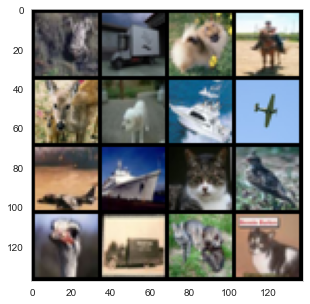

In [41]:
images, _ = next(iter(train_dataloader))
images = images * 0.5 + 0.5 # undo normalization for displaying images
plt.figure(figsize=(5,5))
plt.imshow(torchvision.utils.make_grid(images, nrow=4).permute(1, 2, 0))

In [77]:
class SMAIConvNet(nn.Module):
  def __init__(self):
    super(SMAIConvNet, self).__init__()

    self.conv1 = nn.Conv2d(in_channels=3, out_channels=8, kernel_size=3, padding='same')
    self.maxpool1 = nn.MaxPool2d(kernel_size=2)

    # YOUR CODE BEGINS HERE
    # Conv2D with 32 filters, 3x3 kernel and 'same' padding
    # MaxPool2D with with window size 2x2
    self.numk = 32
    self.conv2 = nn.Conv2d(in_channels=8, out_channels=self.numk, kernel_size=3,
      padding='same')
    self.maxpool2 = nn.MaxPool2d(kernel_size=2) # -> 32, 8, 8

    # Conv2D with 32 filters, 3x3 kernel and 'same' padding
    self.conv3 = nn.Conv2d(in_channels=self.numk, out_channels=self.numk, kernel_size=3,
      padding='same')

    # Linear layer with 128 output features
    # Dropout with drop probability of 0.2
    self.fc1 = nn.Linear(in_features=self.numk*8*8, out_features=128)
    self.dropout1 = nn.Dropout(p=0.2)

    # Linear layer with 10 output features
    self.fc2 = nn.Linear(in_features=128, out_features=10)
    # YOUR CODE ENDS HERE

  def forward(self, x):
    x = self.conv1(x)
    x = self.maxpool1(x)
    x = F.relu(x)

    # YOUR CODE BEGINS HERE
    # conv2 > maxpool2 > ReLU
    x = F.relu(self.maxpool2(self.conv2(x)))
    # conv3 > ReLU
    x = F.relu(self.conv3(x))
    # fc1 > dropout1 > ReLU
    x = self.fc1(x.reshape(-1, self.numk*8*8)) # Maintain batch sizes
    x = self.dropout1(x)
    x = F.relu(x)
    # fc2
    x = self.fc2(x)
    # YOUR CODE ENDS HERE
    return x

In [81]:
batch_size = 16     # Needed for summary
summary(SMAIConvNet().to(device), (batch_size, 3, 32, 32))

Layer (type:depth-idx)                   Output Shape              Param #
SMAIConvNet                              --                        --
├─Conv2d: 1-1                            [16, 8, 32, 32]           224
├─MaxPool2d: 1-2                         [16, 8, 16, 16]           --
├─Conv2d: 1-3                            [16, 32, 16, 16]          2,336
├─MaxPool2d: 1-4                         [16, 32, 8, 8]            --
├─Conv2d: 1-5                            [16, 32, 8, 8]            9,248
├─Linear: 1-6                            [16, 128]                 262,272
├─Dropout: 1-7                           [16, 128]                 --
├─Linear: 1-8                            [16, 10]                  1,290
Total params: 275,370
Trainable params: 275,370
Non-trainable params: 0
Total mult-adds (M): 26.93
Input size (MB): 0.20
Forward/backward pass size (MB): 2.38
Params size (MB): 1.10
Estimated Total Size (MB): 3.68

In [82]:
def train(model, device, train_dataloader, optimizer, criterion):
  """trains for one epoch"""
  
  model.train()
  accumulated_loss = 0.0
  for data in train_dataloader:
    (inputs, labels) = data
    inputs = inputs.to(device)
    labels = labels.to(device)

    # YOUR CODE BEGINS HERE
    # 1. zero existing gradients
    optimizer.zero_grad()
    # 2. forward the inputs
    outputs = model(inputs)
    # 3. compute the loss
    loss = criterion(outputs, labels)
    # 4. backprop the loss
    loss.backward()
    # 5. update the weights
    optimizer.step()
    # YOUR CODE ENDS HERE

    accumulated_loss += loss.item()
  return accumulated_loss / len(train_dataloader)

def test(model, device, dataloader, criterion):
  model.eval()
  accumulated_loss = 0.0
  correct = 0
  with torch.no_grad():
    for data in dataloader:
      (inputs, labels) = data
      inputs = inputs.to(device)
      labels = labels.to(device)

      # YOUR CODE BEGINS HERE
      # 1. forward the inputs
      outputs = model(inputs)
      # 2. compute the loss
      loss = criterion(outputs, labels)
      # YOUR CODE ENDS HERE

      outputs = model(inputs)
      loss = criterion(outputs, labels)
      accumulated_loss += loss.item()

      predictions = outputs.argmax(dim=1)
      correct += (predictions == labels).sum()

    num_samples = len(dataloader)
    avg_loss = accumulated_loss / num_samples
    return avg_loss, correct / num_samples
    

In [101]:
model = SMAIConvNet().to(device) # resets parameters

# YOUR CODE BEGINS HERE
# use CrossEntropyLoss
# use SGD with a lr=0.001 and momentum=0.9
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)
# YOUR CODE ENDS HERE

best_val_loss = np.Inf
loss_history = { "train" : [], "validation" : []}
for epoch in range(30):
  train_loss = train(model, device, train_dataloader, optimizer, criterion)  
  loss_history["train"].append(train_loss)

  val_loss, val_acc = test(model, device, valid_dataloader, criterion)
  loss_history["validation"].append(val_loss)

  if val_loss < best_val_loss and (best_val_loss - val_loss) > 1e-3:
    print("new best model")
    torch.save(model.state_dict(), "best_model.pth")
    best_val_loss = val_loss

  print("[%d] training loss: %.2f" % (epoch + 1,train_loss))
  print("[%d] validation loss: %.2f, validation accuracy: %.2f%%" % (epoch + 1, val_loss, val_acc * 100))
  print()

new best model
[1] training loss: 2.06
[1] validation loss: 1.72, validation accuracy: 37.36%

new best model
[2] training loss: 1.57
[2] validation loss: 1.41, validation accuracy: 48.50%

new best model
[3] training loss: 1.38
[3] validation loss: 1.29, validation accuracy: 53.30%

new best model
[4] training loss: 1.26
[4] validation loss: 1.20, validation accuracy: 57.32%

new best model
[5] training loss: 1.17
[5] validation loss: 1.12, validation accuracy: 59.34%

new best model
[6] training loss: 1.08
[6] validation loss: 1.03, validation accuracy: 63.70%

new best model
[7] training loss: 1.00
[7] validation loss: 0.98, validation accuracy: 65.80%

new best model
[8] training loss: 0.94
[8] validation loss: 0.94, validation accuracy: 67.12%

new best model
[9] training loss: 0.88
[9] validation loss: 0.91, validation accuracy: 67.92%

new best model
[10] training loss: 0.82
[10] validation loss: 0.89, validation accuracy: 69.10%

[11] training loss: 0.77
[11] validation loss: 0

In [102]:
# Save the run
torch.save(model.state_dict(), "best_model_t5.pth")
# Saved 1st run - best_model_t1.pth
# Saved 2nd run - best_model_t2.pth
# Saved 3rd run - best_model_t3.pth
# Saved 4th run - best_model_t4.pth

In [103]:
model.load_state_dict(torch.load("best_model.pth"))

test_loss, test_acc = test(model, device, test_dataloader, criterion)
print("test loss: %.2f, test accuracy: %.2f%%" % (test_loss, test_acc * 100))

test loss: 0.89, test accuracy: 69.84%


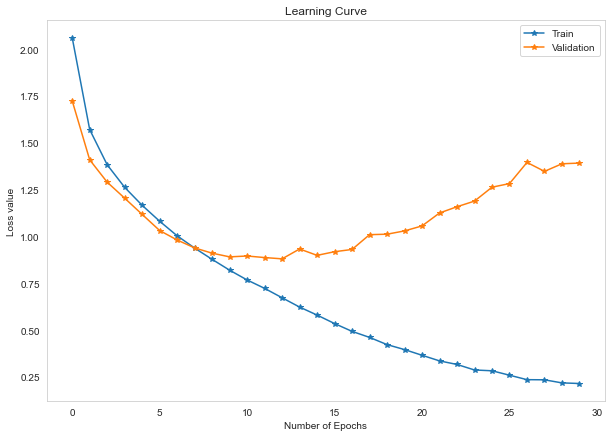

In [105]:
# plot the learning curve
# plot validation and training loss in the same plot against number of epochs (use `loss_history`)
# YOUR CODE BEGINS HERE
plt.figure(figsize=(10, 7))
plt.title("Learning Curve")
plt.plot(loss_history["train"], '-*', label="Train")
plt.plot(loss_history["validation"], '-*', label="Validation")
plt.xlabel("Number of Epochs")
plt.ylabel("Loss value")
plt.legend()
plt.show()
# YOUR CODE ENDS HERE

### Questions

1. What do you observe in the learning curve? Why do we require a validation set?
2. Train the network five times. Note the following quantities in a table (in the code cell below):
  - final training loss
  - best model validation loss and accuracy
  - best model test accuracy
3. Summarize your observations from the table. Does the performance differ in each round of training? What would happen if design decisions are based solely on the validation set performance from a single round of training?
4. Propose a scheme to summarize the overall performance of the model with statistics from multiple training rounds. Using the the table in the next cell, write code to summarize model performance.


### Answers

Write your answers here.




#### Answer 1: Learning Curve and Validation Curve

As seen in the learning curve, the loss value on the training set is consistently reduced as the training epochs pass. The validation error first reduces, and then later increases. The part where both the errors are decreasing can be said the _learning_ part. After which, when the validation error increases and the training error reduces, comes the _overfitting_ part. Here, the CNN most probably has overfit the given training set (note that we have created the validation split from the training set).

**Why need a Validation Set**?

Time to time, as epochs pass, we'd want to monitor how well the network has generalized to the problem it's solving. For this, we need data that the network hasn't seen yet. We cannot use the test set, because it should be only for the final tests of the model. The test set shouldn't be used either for model selection or hyperparameter tuning. Hence, comes the need for a separate validation set, which is taken from the training set. 

#### Answer 2: Data across multiple trainings

The network was trained multiple times and the resulting model was stored in files `best_model_t[1-5].pth`. The original model (first run) was also stored in `best_model.pth`.

In [114]:
# fill the table with numbers from different rounds of training (ex: "training loss" : [1.21, 1.53, 0.95, 0.55, 1.14])
perf_table = {
    "training_loss" : [0.20, 0.20, 0.21, 0.21, 0.22],
    "validation_loss" : [1.41, 1.40, 1.32, 1.43, 1.39],
    "validation_accuracy" : [68.68, 70.06, 70.20, 69.56, 69.36],
    "test_accuracy" : [68.59, 70.23, 70.75, 69.33, 69.84]
}

df = pd.DataFrame(perf_table)
print(df)

# YOUR CODE BEGINS HERE
# summarize the performance
print()
print("=== Mean of all metrics accross multiple training rounds ===")
print(df.mean())
print()
print("=== Var. of all metrics accross multiple training rounds ===")
print(df.var())
# YOUR CODE ENDS HERE

   training_loss  validation_loss  validation_accuracy  test_accuracy
0           0.20             1.41                68.68          68.59
1           0.20             1.40                70.06          70.23
2           0.21             1.32                70.20          70.75
3           0.21             1.43                69.56          69.33
4           0.22             1.39                69.36          69.84

=== Mean of all metrics accross multiple training rounds ===
training_loss           0.208
validation_loss         1.390
validation_accuracy    69.572
test_accuracy          69.748
dtype: float64

=== Var. of all metrics accross multiple training rounds ===
training_loss          0.00007
validation_loss        0.00175
validation_accuracy    0.36832
test_accuracy          0.69012
dtype: float64


#### Answer 3: Performance in each round of training

Yes, the performance differs (slightly) in each round of training. This can be attributed to the fact that the network has generalized well on the training dataset (at least to the same extent). The slight difference in various runs could be because of different random initializations and different shuffling of datasets (into training and validation).

A single round of training shouldn't decide the decisions for all hyperparameter selections. In fact, it should first be observed if the model can produce consistent results. Only then, should we change hyperparameters using the results based on validation accuracy. If design decisions are made from a single round of training, then it could happen that the corrections / actions applied might not have the intended effects. A single round of training doesn't provide enough insights into stability of the model (without which, we cannot conclude anything on generalizing power of our model).

#### Answer 4: Summarize multiple training rounds

There are multiple ways one could do this. One could be representing the values as tolerance bounds (mean $\pm$ deviation). Another method is to find the mean and variance and specify those as results. Ideally, we want a mean with very low variance (which we got). Usually, plotting against several training rounds might not give some deep insights.

The model performance was summarized in the code cell above. Critical insight that can be derived from this is that the variance on test accuracy is greater than the variance on validation accuracy. This shows that the model has still performed slightly more consistent (giving the same results) on the validation set (note that both are unseen during training).